# Data Preprocessing Sample Code for Route 123

In [1]:
import pandas as pd
from datetime import datetime, timedelta
%matplotlib inline
import json
import matplotlib.pyplot as plt
import pickle
import json
import math
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")


### Loading Data

In [2]:
data = pd.read_csv("data/123",sep = "\t" , header = None)

#### Remove invalid data points

In [3]:
data = data[(data[4]> 113.02) & (data[4]<113.15)]
data = data[(data[5]> 22.95) & (data[5]<23.1)]


In [4]:
seconds = [str(s).zfill(2)  for s in range(60)]
minutes = [str(s).zfill(2)  for s in range(60)]
hours = [str(s).zfill(2)  for s in range(24)]
months = [str(s).zfill(2)  for s in range(1,13)]

data = data[data[6].str[-2:].isin(seconds)]
data = data[data[6].str[-5:-3].isin(minutes)]
data = data[data[6].str[-8:-6].isin(hours)]
data = data[data[6].str[5:7].isin(months)]
data = data[data[6].str[:4].isin(["2015"])]
data = data.reset_index(drop=True)

In [5]:
df = data.reset_index()

In [6]:
df.columns = ["raw_index","GPS", "licence_plate_number","route","direction","longitude","latitude",
               "calibrated_time","velocity","angle","raw_time"]

In [7]:
add_speed_data = pd.DataFrame(columns=["raw_index","GPS", "licence_plate_number","route","direction","longitude","latitude",
               "calibrated_time","velocity","angle","raw_time","lon_cp","lat_cp","time_cp","delta_lon", "delta_lat","delta_time"])

# create a new column for the change in lat, lon and time since last data point
for plate in df["licence_plate_number"].unique():
    bus_df = df[df["licence_plate_number"] == plate]
    bus_df = bus_df.reset_index(drop = True)
    bus_df.loc[:,"lon_cp"] = bus_df.loc[:,"longitude"]
    bus_df.loc[:,"lat_cp"] = bus_df.loc[:,"latitude"]
    bus_df.loc[:,"time_cp"] = bus_df.loc[:,"calibrated_time"]
    bus_df.lon_cp = bus_df.lon_cp.shift(1)
    bus_df.lat_cp = bus_df.lat_cp.shift(1)
    bus_df.time_cp = bus_df.time_cp.shift(1)
    bus_df.loc[:,"delta_lon"] = bus_df.loc[:,"longitude"] -  bus_df.loc[:,"lon_cp"]
    bus_df.loc[:,"delta_lat"] = bus_df.loc[:,"latitude"] -  bus_df.loc[:,"lat_cp"]
    bus_df.loc[:,"delta_time"] = pd.to_datetime(bus_df.loc[:,"calibrated_time"]) -  pd.to_datetime(bus_df.loc[:,"time_cp"])
    add_speed_data = pd.concat([add_speed_data, bus_df])

add_speed_data.head()

,raw_index,GPS,licence_plate_number,route,direction,longitude,latitude,calibrated_time,velocity,angle,raw_time,lon_cp,lat_cp,time_cp,delta_lon,delta_lat,delta_time
0,0,GPS,粤E13706,123,-1,113.07685,23.051683,2015-07-01 00:01:18,-1,-1,2015-07-01 00:01:22,NaN,NaN,NaN,NaN,NaN,NaT
1,10,GPS,粤E13706,123,-1,113.07685,23.051683,2015-07-01 00:01:23,-1,-1,2015-07-01 00:01:26,113.07685,23.051683,2015-07-01 00:01:18,0.0,0.0,00:00:05
2,21,GPS,粤E13706,123,-1,113.07685,23.051683,2015-07-01 00:01:28,-1,-1,2015-07-01 00:01:31,113.07685,23.051683,2015-07-01 00:01:23,0.0,0.0,00:00:05
3,33,GPS,粤E13706,123,-1,113.07685,23.051683,2015-07-01 00:01:33,-1,-1,2015-07-01 00:01:38,113.07685,23.051683,2015-07-01 00:01:28,0.0,0.0,00:00:05
4,44,GPS,粤E13706,123,-1,113.07685,23.051683,2015-07-01 00:01:38,-1,-1,2015-07-01 00:01:42,113.07685,23.051683,2015-07-01 00:01:33,0.0,0.0,00:00:05


In [8]:
complete_df = add_speed_data[["raw_index","route","licence_plate_number","calibrated_time","longitude",
                              "latitude", "delta_lon", "delta_lat","delta_time"]]
complete_df = complete_df.set_index("raw_index")

complete_df.head()

,route,licence_plate_number,calibrated_time,longitude,latitude,delta_lon,delta_lat,delta_time
raw_index,,,,,,,,
0,123,粤E13706,2015-07-01 00:01:18,113.07685,23.051683,NaN,NaN,NaT
10,123,粤E13706,2015-07-01 00:01:23,113.07685,23.051683,0.0,0.0,00:00:05
21,123,粤E13706,2015-07-01 00:01:28,113.07685,23.051683,0.0,0.0,00:00:05
33,123,粤E13706,2015-07-01 00:01:33,113.07685,23.051683,0.0,0.0,00:00:05
44,123,粤E13706,2015-07-01 00:01:38,113.07685,23.051683,0.0,0.0,00:00:05


In [9]:
complete_df = complete_df.drop_duplicates(subset=["calibrated_time","longitude","latitude"], keep="first")
complete_df = complete_df[complete_df["delta_time"].isin(list(complete_df["delta_time"].value_counts().index[:6]))]

In [10]:
complete_df["delta_time"] = complete_df["delta_time"].dt.seconds

In [11]:
complete_df.to_csv("data/123_edit",sep = "\t")

### Finding Stop Location

Find all data points that indicate that the bus stopped for more than a few seconds.
Filter them base on rules.
Then do clustering to find potential bus location.

In [15]:
complete_df = pd.read_csv("data/123_edit",sep = "\t")

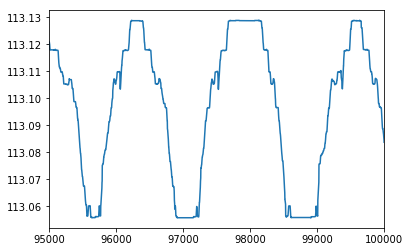

In [18]:
complete_df.loc[95000:100000,"longitude"].plot()


In [19]:
complete_df['calibrated_time'] = pd.to_datetime(complete_df['calibrated_time'])

#### Find out locations that bus stopped for more than 15 seconds

In [20]:
not_working = []
for plate in complete_df["licence_plate_number"].unique():
    bus1 = complete_df[complete_df["licence_plate_number"] == plate]
    first_index = bus1.index[0]
    last_loc = (bus1.loc[first_index]["longitude"], bus1.loc[first_index]["latitude"])
    caching = []
    
    for index, row in bus1.iterrows():
        if row["longitude"] == last_loc[0] and row["latitude"] == last_loc[1]:
            caching.append(index)
        else:
            if len(caching) > 1:
                not_working.append(caching)
            caching = [index]
            last_loc = (row["longitude"], row["latitude"])
    

print len(not_working)

295453


In [21]:
# find the start and the end of evrey not_working period, and calculate the gap between them
stop_index_15 = [point[0] for point in not_working if (complete_df.loc[point[-1],"calibrated_time"] - complete_df.loc[point[0],"calibrated_time"]).total_seconds() > 15]

In [22]:
stop_loc_15_df = complete_df.loc[stop_index_15][["longitude","latitude"]]
# stop_loc_15_df = stop_loc_15_df[(stop_loc_15_df["latitude"]>23.02)& (stop_loc_15_df["latitude"]<23.06) &
#                           (stop_loc_15_df["longitude"]>113.00) &(stop_loc_15_df["longitude"]<113.2)]

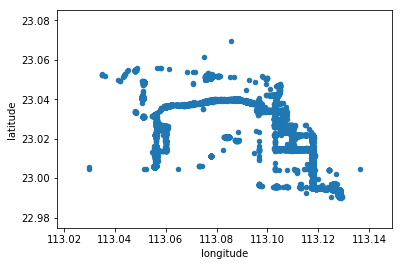

In [23]:
stop_loc_15_df.plot.scatter(x = "longitude", y = "latitude")

#### Give each data point a score

In [24]:
count = 0
stop_loc_15_df["nearby"] = 0
for i in stop_loc_15_df.index:
    count += 1
    stop_loc_15_df.loc[i,"nearby"] = stop_loc_15_df[(stop_loc_15_df["longitude"] > (stop_loc_15_df.loc[i,"longitude"] - 0.0002))&
                                              (stop_loc_15_df["longitude"] < (stop_loc_15_df.loc[i,"longitude"] + 0.0002))&
                                              (stop_loc_15_df["latitude"] > (stop_loc_15_df.loc[i,"latitude"]-0.0002))&
                                              (stop_loc_15_df["latitude"] < (stop_loc_15_df.loc[i,"latitude"]+0.0002))].shape[0]

stop_loc_15_df.head()

,longitude,latitude,nearby
0,113.076850,23.051683,1693
1060,113.076283,23.052017,2912
1117,113.076533,23.052050,2843
3632,113.076350,23.052017,3268
3752,113.076417,23.052133,2905


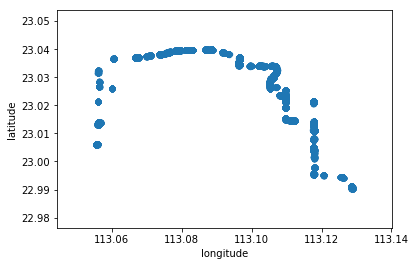

In [25]:
stop_loc_15_df_unique = stop_loc_15_df.drop_duplicates().sort_values("nearby",ascending = False)
stop_loc_15_df_unique = stop_loc_15_df_unique[stop_loc_15_df_unique["latitude"] < 23.045 ]
stop_loc_15_df_unique = stop_loc_15_df_unique[(stop_loc_15_df_unique["nearby"]<10000)&(stop_loc_15_df_unique["nearby"]>200)]
stop_loc_15_df_unique.plot.scatter("longitude","latitude")

In [26]:
from sklearn.cluster import DBSCAN
DB = DBSCAN(eps=0.0005, min_samples=600).fit(stop_loc_15_df_unique[["longitude","latitude"]])
loc = pd.DataFrame(DB.components_.tolist())
loc.index = DB.core_sample_indices_
loc.columns = ["lon","lat"]
lab = pd.DataFrame(DB.labels_)
lab.columns = ["label"]
df = pd.concat([loc, lab], axis=1)
df = df.dropna(axis=0, how='any')
stop_loc = df.groupby("label").mean()

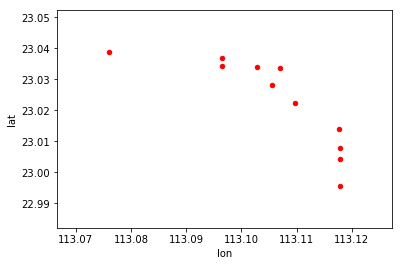

In [27]:
stop = stop_loc[(stop_loc.lon<113.12)&(stop_loc.lon>113.06)]
stop.plot(x="lon", y= "lat", kind = "scatter",color = "red")

In [111]:
# stop.to_csv("data/stoploc.csv")


### Cutting the sequence into shifts

In [28]:
complete_df['calibrated_time'] = pd.to_datetime(complete_df['calibrated_time'])
start_range = [(113.128, 113.130), (22.9895, 22.9915)]
end_range = [(113.055, 113.057), (23.005, 23.007)]
shifts = []

for bus in complete_df.licence_plate_number.unique().tolist()[:]:
    temp = []
    temp_bus = complete_df[complete_df.licence_plate_number == bus]
    for i in temp_bus.index:
        if temp_bus.loc[i,"longitude"] < start_range[0][1] and temp_bus.loc[i,"longitude"] > start_range[0][0] and temp_bus.loc[i,"latitude"] < start_range[1][1] and temp_bus.loc[i,"latitude"] > start_range[1][0]:
            # if within departure station, renew the shift list
#             temp = [(i, temp_bus.loc[i,"longitude"], temp_bus.loc[i,"latitude"])]
            temp = [i]
        elif temp_bus.loc[i,"longitude"] < end_range[0][1] and temp_bus.loc[i,"longitude"] > end_range[0][0] and temp_bus.loc[i,"latitude"] < end_range[1][1] and temp_bus.loc[i,"latitude"] > end_range[1][0]:
            # if within terminal station, check if the length of the list satisfied our requirement
            if len(temp)> 100 :
                if (temp_bus.loc[temp[-1],"calibrated_time"] - temp_bus.loc[temp[0],"calibrated_time"]).total_seconds()>3600 and (temp_bus.loc[temp[-1],"calibrated_time"] - temp_bus.loc[temp[0],"calibrated_time"]).total_seconds()<9600 :
                    shifts.append(temp)
            temp = []

        elif len(temp)>0:
            # if between the two stations, add it to the list
#             temp.append((i, temp_bus.loc[i,"longitude"], temp_bus.loc[i,"latitude"]))
            temp.append(i)


In [29]:
valid_shift = []

# further filter previously selected shifts
for shift in shifts[:]:
    # find out the index of each data point
    ind = [s for s in shift]
    # standardize the time based on the starting point
    timelist = list(pd.to_datetime(complete_df.loc[ind]["calibrated_time"]))
    # time past
    timelist = [timedelta.total_seconds(t-timelist[0]) for t in timelist if timedelta.total_seconds(t-timelist[0])< 8000 and timedelta.total_seconds(t-timelist[0])> 0]
    #plate number
    platelist = list(complete_df.loc[ind]["licence_plate_number"])
    #lon
    xlist = list(complete_df.loc[ind]["longitude"])
    #lat
    ylist = list(complete_df.loc[ind]["latitude"])
    # timestamp
    tlist = list(complete_df.loc[ind]["calibrated_time"])
    #delta lon
    deltax = list(complete_df.loc[ind]["delta_lon"])
    #delta lat
    deltay = list(complete_df.loc[ind]["delta_lat"])
    #delta time
    deltat = list(complete_df.loc[ind]["delta_time"])
    
    temp = zip(platelist, xlist, ylist, tlist, timelist, deltax, deltay, deltat)
    
    if max(xlist)>113.2:
        continue
    valid_shift.append(temp)


#### Identify stop location

In [ ]:
# stop = pd.read_csv("data/stoploc_116.csv",sep = ",")

In [30]:
agg_df = pd.DataFrame(columns = ["Plate", "Lon", "Lat", "Timestamp", "timepast",
                                     "deltalon", "deltalat", "deltat", "speed", "deltad", "distance",
                                 "average_speed", "speed_smooth_3", "speed_smooth_5", "speed_smooth_10", "shift", "train_test"])

for shift, shift_data in enumerate(valid_shift):
    shift_df = pd.DataFrame(shift_data)
    shift_df.columns = ["Plate", "Lon", "Lat", "Timestamp", "timepast", "deltalon", "deltalat", "deltat"]
    shift_df["speed"] = ((shift_df["deltalat"]*100000)**2 + (shift_df["deltalat"]*100000)**2).apply(math.sqrt) / shift_df["deltat"]
    shift_df["deltad"] = shift_df["speed"] * shift_df["deltat"]
    shift_df["distance"] = shift_df["deltad"].expanding().sum()
    shift_df["average_speed"] = shift_df["distance"] / shift_df["timepast"]
    shift_df["speed_smooth_3"] = shift_df["speed"].rolling(window=3).mean()
    shift_df["speed_smooth_5"] = shift_df["speed"].rolling(window=5).mean()
    shift_df["speed_smooth_10"] = shift_df["speed"].rolling(window=10).mean()
    shift_df["shift"] = shift
    shift_df["train_test"] = 1 if random.random() > 0.8 else 0
    agg_df = agg_df.append(shift_df, ignore_index = True)

print agg_df.head()

     Plate         Lon        Lat           Timestamp  timepast  deltalon  \
0  粤E13706  113.128550  22.991267 2015-07-01 07:49:34       5.0  0.000000   
1  粤E13706  113.128550  22.991600 2015-07-01 07:49:39      10.0  0.000000   
2  粤E13706  113.128517  22.991917 2015-07-01 07:49:44      15.0 -0.000033   
3  粤E13706  113.128483  22.992300 2015-07-01 07:49:49      20.0 -0.000033   
4  粤E13706  113.128450  22.992717 2015-07-01 07:49:54      25.0 -0.000033   

   deltalat deltat      speed     deltad    distance  average_speed  \
0  0.000233      5   6.599663  32.998316   32.998316       6.599663   
1  0.000333      5   9.428090  47.140452   80.138769       8.013877   
2  0.000317      5   8.956686  44.783429  124.922198       8.328147   
3  0.000383      5  10.842304  54.211520  179.133718       8.956686   
4  0.000417      5  11.785113  58.925565  238.059283       9.522371   

   speed_smooth_3  speed_smooth_5  speed_smooth_10 shift train_test  
0             NaN             NaN       

In [31]:
agg_df["Lon_round"] = agg_df["Lon"].round(4)
agg_df["Lat_round"] = agg_df["Lat"].round(4)
grid_df = agg_df[agg_df["train_test"] == 0].groupby(["Lon_round", "Lat_round"])[["timepast", "speed_smooth_3", "speed_smooth_5", "speed_smooth_10"]].mean()
grid_df = grid_df.reset_index()
grid_df.columns = ["Lon_round", "Lat_round", "time_avg", "speed_avg_3", "speed_avg_5", "speed_avg_10"]
new_df = pd.merge(agg_df, grid_df,  how='left', left_on=['Lon_round','Lat_round'], right_on = ['Lon_round','Lat_round'])


In [32]:
new_df["delay"] = new_df["timepast"] - new_df["time_avg"]
new_df["delay_12"] = new_df["delay"].shift(12)
new_df["delay_24"] = new_df["delay"].shift(24)
new_df["delay_36"] = new_df["delay"].shift(36)
new_df["delay_48"] = new_df["delay"].shift(48)
new_df["delay_60"] = new_df["delay"].shift(12)

In [33]:
stop_dic = {}
for index, row in stop.iterrows():
    stop_dic[index] = []


In [ ]:

for shift in range(len(valid_shift)):

    res_df = pd.DataFrame(columns = [u'Plate', u'Lon', u'Lat', u'Timestamp', u'timepast', u'deltalon',
                                     u'deltalat', u'deltat', u'speed', u'deltad', u'distance',
                                     u'average_speed', u'speed_smooth_3', u'speed_smooth_5',
                                     u'speed_smooth_10', u'shift', u'train_test', u'Lon_round', u'Lat_round',
                                     u'time_avg', u'speed_avg_3', u'speed_avg_5', u'speed_avg_10', u'delay',
                                     u'delay_12', u'delay_24', u'delay_36', u'delay_48', u'delay_60', u'timeleft',
                                     u'tostop', u'stoplon', u'stoplat',
                                    ])

    shift_df = new_df[new_df["shift"] == shift]
    
    stop_info = []
    
    for index, row in stop.iterrows():
        lon_range = [row["lon"] - 0.0002, row["lon"] + 0.0002]
        lat_range = [row["lat"] - 0.0002, row["lat"] + 0.0002]
        
        for point in shift_df.iterrows():
            if point[1]["Lon"] < lon_range[1] and point[1]["Lon"] > lon_range[0] and point[1]["Lat"] < lat_range[1] and point[1]["Lat"] > lat_range[0]:
                stop_info.append([index, point[1]["timepast"], point[1]["Lon"], point[1]["Lat"]])
                if point[1]["train_test"] == 0:
                    stop_dic[index].append(point[1]["timepast"])
                break
    # drop those shift deviate from the standard route by too much
    if len(stop_info) < 5:
        continue
    
    for st in stop_info:
        sub_df = shift_df[shift_df.timepast<st[1]]
        sub_df["timeleft"] = st[1] - sub_df.timepast
        sub_df["tostop"] = st[0]
        sub_df["stoplon"] = st[2]
        sub_df["stoplat"] = st[3]
        res_df = res_df.append(sub_df, ignore_index = True)

    res_df.to_csv("shifts_123/%s.csv" % shift)

In [27]:
stop_time_exp = {1: 592.91037735849056,
     2: 1661.625,
     3: 2834.5033444816054,
     5: 1858.8259668508288,
     7: 2245.5670103092784,
     8: 304.01388888888891,
     9: 2340.3162393162393,
     10: 661.05359877488513,
     11: 2073.8668831168829,
     12: 1296.5062499999999,
     13: 849.73932926829264
}

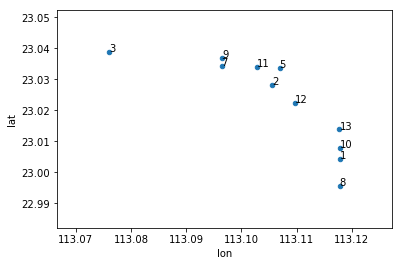

In [130]:
fig, ax = plt.subplots()
stop.plot.scatter(x = "lon", y = "lat", ax = ax)
for k, v in stop.iterrows():
    ax.annotate(k, v)

In [28]:
stop_order = {
    8:1,
    1:2,
    10:3,
    13:4,
    12:5,
    2:6,
    5:7,
    11:8,
    7:9,
    9:10,
    3:11
}

### Add ordinal stop to the data

In [42]:
complete_df = pd.DataFrame()
count = 0
for shift in range(1000):
    try:
#         print shift
        shift_df = pd.read_csv("shifts_123/%s.csv" % shift)
        if shift_df[(shift_df["Lat"] > 22.99) & (shift_df["Lat"] < 23.01) 
                    & (shift_df["Lon"] < 113.10) & (shift_df["Lon"] < 113.11)].shape[0] > 0:
            continue
        if shift_df[shift_df["Lat"]>23.045].shape[0]>0:
            continue
        if shift_df[(shift_df["Lat"] > 22.99) & (shift_df["Lat"] < 23.01) 
                    & (shift_df["Lon"] < 113.115) & (shift_df["Lon"] > 113.09)].shape[0] > 0:   
            continue
            
        shift_df["tostop_estimate"] = shift_df["tostop"].apply(lambda x:stop_time_exp[x])
        shift_df["ordinal_stop"] = shift_df["tostop"].apply(lambda x:stop_order[x])
        shift_df.to_csv("shifts_123_valid/%s.csv" % shift)
    except:
        pass